### 0.导入函数库

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import obspy
from obspy.core import read
from obspy import read_events
from obspy import read_inventory
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.cross_correlation import correlate
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt
from obspy.signal.rotate import rotate_lqt_zne
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

### 1.波形旋转
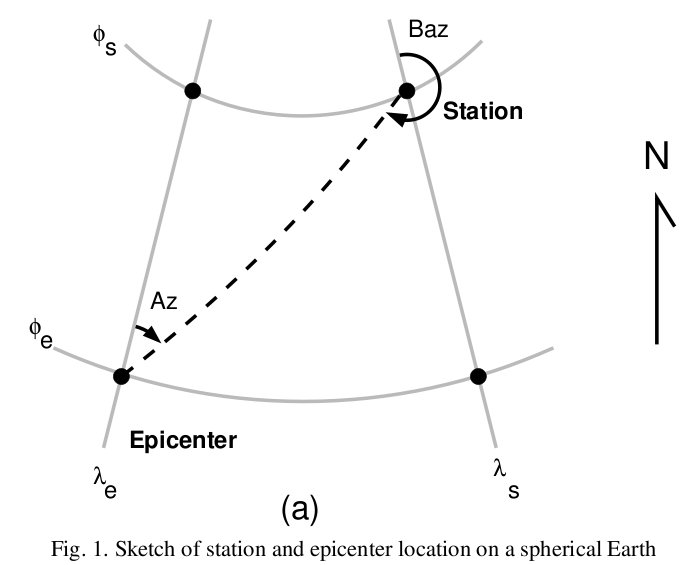

Epicentral distance [m]:  9127350.828896653
Theoretical azimuth [deg]:  329.4079811585143
Theoretical backazimuth [deg]:  37.602787067079454


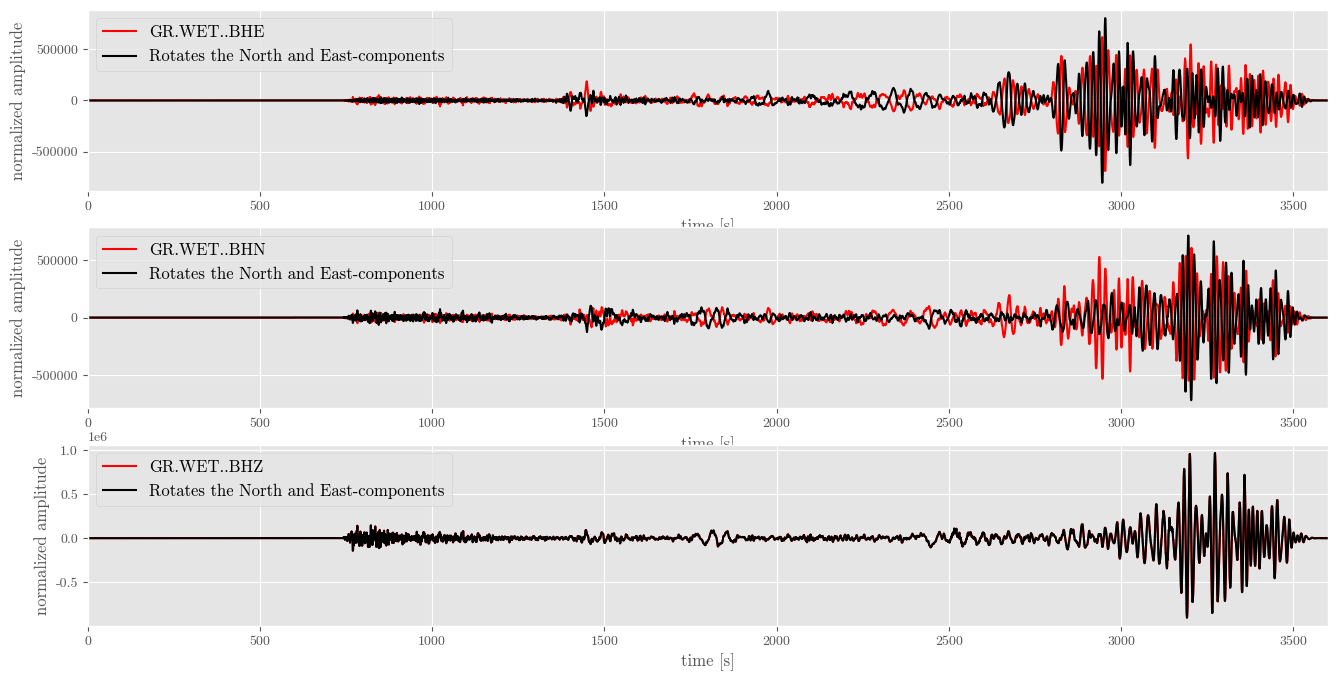

In [8]:
inv = read_inventory("../data/gr_wet.xml")
cat = read_events("../data/iris_catalog.xml")
event = cat[0]
# print(cat)
AC = read("../data/event_bfg.mseed")
AC.detrend(type='linear')
AC.taper(max_percentage=0.05)


startaim = max([tr.stats.starttime for tr in (AC)])
endtaim = min([tr.stats.endtime for tr in (AC)])

paz_sts2 = {'poles': [(-0.0367429 + 0.036754j), (-0.0367429 - 0.036754j)],
            'sensitivity': 0.944019640,
            'zeros': [0j],
            'gain': 1.0}

AC.simulate(paz_remove=paz_sts2, remove_sensitivity=True)
AC.trim(startaim, endtaim, nearest_sample=True)
AC.decimate(factor=4)
high_cut = 1.0
low_cut = 0.005

AC.filter('bandpass', freqmax=high_cut, freqmin=low_cut, corners=2, zerophase=True)

source_latitude = event.origins[0].latitude
source_longitude = event.origins[0].longitude
station_latitude = 49.144001
station_longitude = 12.8782

baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

print('Epicentral distance [m]: ', baz[0])
print('Theoretical azimuth [deg]: ', baz[1])
print('Theoretical backazimuth [deg]: ', baz[2])

# 北向和东向分量旋转为径向和横向分量
AC_NE_RT = AC.copy()
AC_NE_RT.rotate(method='NE->RT',back_azimuth=baz[2])

# 绘图
fig, ax = plt.subplots(3, 1, figsize=(16, 8))

ax[0].plot(AC[0].times(), AC[0].data, 'r', label=AC[0].id)
ax[0].plot(AC_NE_RT[0].times(), AC_NE_RT[0].data, 'k', label='Rotates the North and East-components')
ax[0].legend(loc=2, prop={"size":12})
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('normalized amplitude')
ax[0].set_xlim(0,max(AC[0].times()))

ax[1].plot(AC[1].times(), AC[1].data, 'r', label=AC[1].id)
ax[1].plot(AC_NE_RT[1].times(), AC_NE_RT[1].data, 'k', label='Rotates the North and East-components')
ax[1].legend(loc=2, prop={"size":12})
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('normalized amplitude')
ax[1].set_xlim(0,max(AC[1].times()))

ax[2].plot(AC[2].times(), AC[2].data, 'r', label=AC[2].id)
ax[2].plot(AC_NE_RT[2].times(), AC_NE_RT[2].data, 'k', label='Rotates the North and East-components')
ax[2].legend(loc=2, prop={"size":12})
ax[2].set_xlabel('time [s]')
ax[2].set_ylabel('normalized amplitude')
ax[2].set_xlim(0,max(AC[2].times()))

plt.show()


### 2.波形相关分析

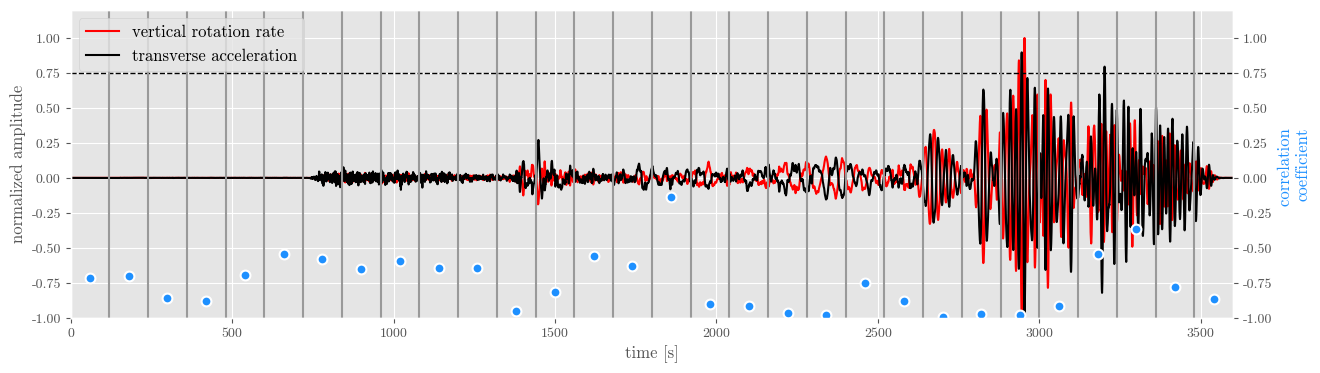

In [9]:
AC_RT = AC_NE_RT[0]
AC_OR = AC[0]

sampling_rate = int(AC_RT.stats.sampling_rate)
sec = 120  

# 计算相关系数
corrcoefs = []
for ic in range(0, len(AC_RT) // (int(sampling_rate * sec))):
    coeffs = correlate(AC_RT.data[sampling_rate * sec * ic : sampling_rate * sec * (ic + 1)],
                    AC_OR.data[sampling_rate * sec * ic : sampling_rate * sec * (ic + 1)], 0)
    corrcoefs.append(coeffs[0])

# 绘图
plt.figure(figsize=(15,4))
ax=plt.subplot(111)
ax.plot(AC_RT.times(), AC_RT.data/np.max(np.abs(AC_RT.data)), 'r', label='vertical rotation rate')
ax.plot(AC_OR.times(), AC_OR.data/np.max(np.abs(AC_OR.data)), 'k', label='transverse acceleration')
ax.set_xlabel('time [s]')
ax.set_ylabel('normalized amplitude')
ax.set_ylim(-1.0,1.2)
ax.axhline(y=.75, linewidth=1, c='k',ls='dashed')
ax.legend(loc=2, prop={"size":12})
for xi in range(sec,sec * len(corrcoefs)-1, sec):
    ax.axvline(x=xi, color='.6')

ax2=ax.twinx()
ax2.scatter(np.arange(60,sec * len(corrcoefs),sec),corrcoefs,c='Dodgerblue',s=50,edgecolors='w',linewidth=1.5)
ax2.set_xlim(0, AC_RT.times()[-1])
ax2.set_ylim(-1,1.2)
ax2.set_ylabel('correlation \ncoefficient', color='Dodgerblue')
# ax2.annotate('0.75 threshold', xy=(1000,.8),xycoords='data')
ax2.grid(visible=False)

plt.show()

### 4.频散分析

### 4.小波分析

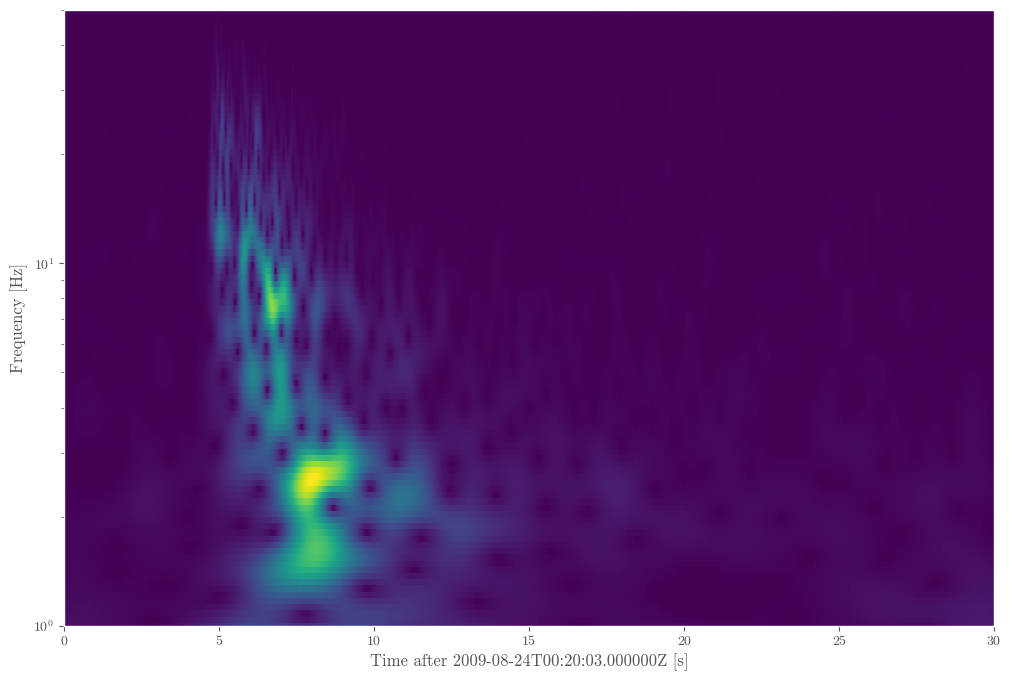

In [10]:
st = obspy.read("../data/detrend_test_stream.mseed")
tr = st[0]
npts = tr.stats.npts
dt = tr.stats.delta
t = np.linspace(0, dt * npts, npts)
f_min = 1
f_max = 50

scalogram = cwt(tr.data, dt, 8, f_min, f_max)

fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(
    t,
    np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
ax.set_ylabel("Frequency [Hz]")
ax.set_yscale('log')
ax.set_ylim(f_min, f_max)
plt.show()